In [105]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import gc
import pdet
import fpfs
import fitsio
import pltutil
import numpy as np
import numpy.lib.recfunctions as rfn
import matplotlib.pylab as plt

ver='try4'
gver='basic2'
dver='cut16'
#dver='det'
wrkDir=os.environ['homeWrk']
simDir=os.path.join(wrkDir,'FPFS2/sim/')
def truncSine_func(x,mu=0.,sigma=1.5,deriv=0):
    t=(x-mu)/sigma
    if deriv==0:
        return np.piecewise(t, [t<-1,(t>=-1)&(t<=1),t>1], [0.,lambda t:1./2.+np.sin(t*np.pi/2.)/2., 1.])
    elif deriv==1:
        # multiplicative factor for the first derivative
        return np.piecewise(t, [t<-1+0.01,(t>=-1+0.01)&(t<=1-0.01),t>1-0.01],[0.,lambda t: np.pi/2./sigma*np.cos(t*np.pi/2.)/(1.+np.sin(t*np.pi/2.)), 0.] )


def sigmoid_func(x,mu=0.,sigma=1.5,deriv=0):
    expx=np.exp(-(x-mu)/sigma)
    if deriv==0:
        # sigmoid function
        return 1./(1. + expx)
    elif deriv==1:
        # multiplicative factor for the first derivative
        return 1./sigma*expx/(1. + expx)

def get_detbias(dets,ells,w_sel,icut,isig,ind):
    """
    Args:
        dets:       detection array
        ells:       ellipticity array
        w_sel:      selection weight
        icut:       selection cut
        isig:       sigma of sigmoid function
        inds:       pixel index

    Returns:
        cor1:       correction for shear1
        cor2:       correction for shear2
    """
    fnmv   =  'pdet_v%d%d'  %ind
    fnmr1  =  'fpfs_e1v%d%dr1'%ind
    fnmr2  =  'fpfs_e2v%d%dr2'%ind
    if use_sig:
        wselb  =  sigmoid_func(dets[fnmv],mu=icut,sigma=isig,deriv=1)
    else:
        wselb  =  truncSine_func(dets[fnmv],mu=icut,sigma=isig,deriv=1)
    out1=np.sum(ells[fnmr1]*wselb*w_sel)
    out2=np.sum(ells[fnmr2]*wselb*w_sel)
    return out1,out2

def get_detbias_list(dets,ells,w_sel,indsl,cutsl,bcutl):
    """
    get detection bias due to lower boundar cuts
    Args:
        dets:       ndarray
                    detection array
        ells:       ndarray
                    ellipticity array
        w_sel:      ndarray
                    selection weight
        indsl:      list
                    a list of pixel index
        cutsl:      list
                    a list of selection cuts (sigmoid mu)
        bcutl:      list
                    a list of width of sigmoid functions
    """
    ncut = len(indsl) # assert
    assert len(cutsl)==ncut, 'number of cuts does not match'
    assert len(bcutl)==ncut, 'number of boundary bin size does not match'

    cor1Sum=0.  # initialize the correction terms
    cor2Sum=0.
    for _ in range(ncut):
        fnmv =  'pdet_v%d%d' %indsl[_]
        bcut  =  bcutl[_]
        icut  =  cutsl[_]
        print('apply cut on %s at %.3f' %(fnmv,icut))
        c1,c2=get_detbias(dets,ells,w_sel,icut,bcut,indsl[_])
        cor1Sum+=c1
        cor2Sum+=c2
    return cor1Sum,cor2Sum

def get_selbias(cut,rev,w_sel,icut,isig):
    """
    Args:
        dets:       detection array
        w_sel:      selection weight
        icut:       selection cut
        isig:       sigma of sigmoid function

    Returns:
        cor1:       correction for shear1
        cor2:       correction for shear2
    """
    if use_sig:
        wselb  =  sigmoid_func(cut,mu=icut,sigma=isig,deriv=1)
    else:
        wselb  =  truncSine_func(cut,mu=icut,sigma=isig,deriv=1)
    out1=np.sum(rev*wselb*w_sel)
    out2=np.sum(rev*wselb*w_sel)
    return out1,out2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
32**2/0.28243/np.sqrt(np.pi)

2045.5692863821212

In [ ]:
nver='var4em3' # 'var0em0'# 'var1em9'
hdat=fitsio.read(os.path.join(simDir,'srcfs2_%sCenter-%s_%s/psf60/src-0000-g1-0000.fits' %(gver,nver,ver)))
fdat=fitsio.read(os.path.join(simDir,'srcfs2_%sCenter-%s_%s/psf60/fpfs-%s-0000-g1-0000.fits' %(gver,nver,ver,dver)))
hdat=hdat[hdat['parent']==0]
ipos1=np.int_((hdat['base_NaiveCentroid_y']//64*100)+hdat['base_NaiveCentroid_x']//64)
ipos2=np.int_((fdat['pdet_y']//64*100)+fdat['pdet_x']//64)
assert np.all(ipos2==np.arange(10000))
fdat=fdat[ipos1]


Const  =   0.
edat=fpfs.catutil.fpfsM2E(fdat,dets=None,const=Const,noirev=False)

fig,axes=pltutil.make_figure_axes(ny=2,nx=1)

ax=axes[0]
ax.scatter(fdat['fpfs_M00']/32.**2.,hdat['base_SdssShape_instFlux'],s=0.04,color='black')
ax.set_xlabel('fpfs flux')
ax.set_ylabel('SDSS flux')
ax.set_xlim(0.01,1)
ax.set_ylim(1,50)

ax=axes[1]
ax.scatter(edat['fpfs_s0']-edat['fpfs_s2'],hdat['ext_shapeHSM_HsmSourceMoments_xx']+hdat['ext_shapeHSM_HsmSourceMoments_yy'],s=0.04,color='black')
#ax.scatter(fdat['fpfs_M00']-fdat['fpfs_M20'],hdat['ext_shapeHSM_HsmSourceMoments_xx']+hdat['ext_shapeHSM_HsmSourceMoments_yy'],s=0.04,color='black')
ax.set_xlabel('fpfs trace')
ax.set_ylabel('regauss trace')
plt.tight_layout()

In [150]:
#nver='var1em9' # 'var0em0'#
nver='var4em3' # 'var0em0'#
#nver='var0em0' # 'var0em0'#
# read noiseless data
outNN1=[]
outNN2=[]
for _i in range(200):
    _a1=fitsio.read(os.path.join(simDir,'srcfs2_%sCenter-%s_%s/psf60/fpfs-%s-%04d-g1-0000.fits' %(gver,nver,ver,dver,_i)))
    _a2=fitsio.read(os.path.join(simDir,'srcfs2_%sCenter-%s_%s/psf60/fpfs-%s-%04d-g1-2222.fits' %(gver,nver,ver,dver,_i)))
    outNN1.append(_a1)
    outNN2.append(_a2)
    del _a1,_a2#,msk1,msk2
outNN1 =   rfn.stack_arrays(outNN1,usemask=False)
outNN2 =   rfn.stack_arrays(outNN2,usemask=False)
detM1=   pdet.peak2det(outNN1)
detM2=   pdet.peak2det(outNN2)

In [151]:
Const  =   3e-2
noirev =   True
ellM1  =   fpfs.catutil.fpfsM2E(outNN1,dets=detM1,const=Const,noirev=noirev)
ellM2  =   fpfs.catutil.fpfsM2E(outNN2,dets=detM2,const=Const,noirev=noirev)
gc.collect()

1286

In [123]:
np.sqrt(outNN1['fpfs_N00N00'])

array([0.00666131, 0.00666131, 0.00666131, ..., 0.00666131, 0.00666131,
       0.00666131])

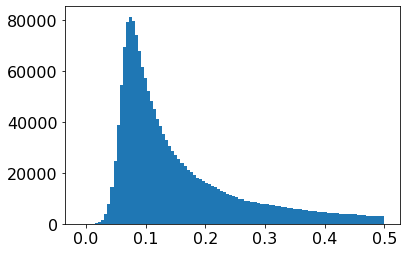

In [144]:
_=plt.hist(detM1['pdet_v22'],range=(-0.01,0.5),bins=100)

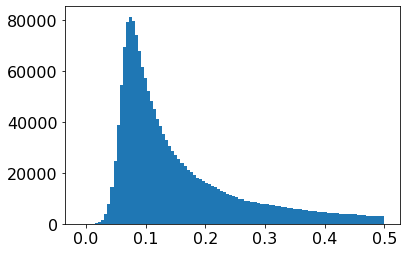

In [143]:
_=plt.hist(outNN1['fpfs_M00'],range=(-0.01,0.5),bins=100)

In [126]:
outNN1['fpfs_M00']/detM1['pdet_v22']

array([1.0000053 , 0.99999639, 1.00000016, ..., 0.99999538, 1.00000413,
       0.99999982])

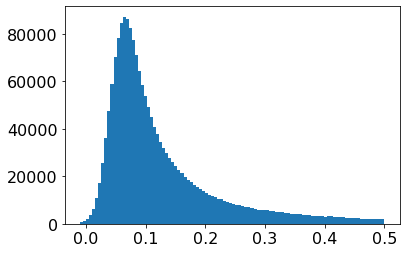

In [141]:
_=plt.hist(-outNN1['fpfs_M20'],range=(-0.01,0.5),bins=100)

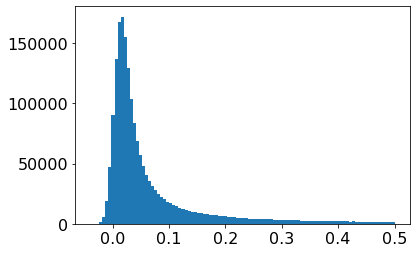

In [147]:
plt.close()
_=plt.hist(outNN1['fpfs_M00']+outNN1['fpfs_M20'],range=(-0.04,0.5),bins=100)

0.0
0.06
0.12
0.18
0.24
0.3
0.36
0.42
[-0.0015190199026288154, -0.005305710583313417, -0.0059803996610744425, -0.002646238869779882, -0.0014083471210122323, -0.0009158391064755245, -0.0007100301455511548, -0.00043953921628758774]


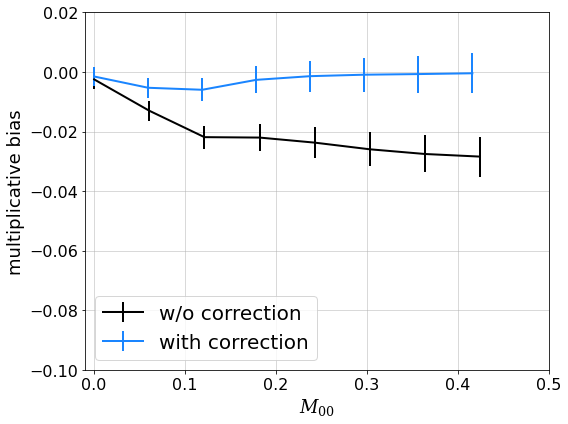

In [152]:
use_sig=False
x=[]
y1=[]
y2=[]
yerr=[]


gc.collect()
plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
    
xlabel='$M_{00}$'
ax.set_xlim(-0.01,0.5)
selnm='fpfs_M00'
cornm='fpfs_RS0'

scol1=outNN1[selnm]
scol2=outNN2[selnm]
ccol1=ellM1[cornm]
ccol2=ellM2[cornm]

dcc=0.06 # delta cut
cutB=0.00 # 
cutsig=0.08
    
for i in range(0,8):
    # update cut array
    cut=cutB+dcc*i
    print(cut)
    
    # weight array
    ws1 = np.ones(len(detM1))
    if use_sig:
        _wtmp= sigmoid_func(scol1,mu=cut,sigma=cutsig)
    else:
        _wtmp= truncSine_func(scol1,mu=cut,sigma=cutsig)
    ws1=ws1*_wtmp
        
    # weight array
    ws2 = np.ones(len(detM2))
    if use_sig:
        _wtmp= sigmoid_func(scol2,mu=cut,sigma=cutsig)
    else:
        _wtmp= truncSine_func(scol2,mu=cut,sigma=cutsig)
    ws2=ws2*_wtmp

    cor1,cor1b = get_selbias(scol1,ccol1,ws1,cut,cutsig)
    cor2,cor2b = get_selbias(scol2,ccol2,ws2,cut,cutsig)
    de   = np.sum(ellM2['fpfs_e1']*ws2)-np.sum(ellM1['fpfs_e1']*ws1)
    rave = (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1))/2.
    raveR= (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1)+cor1+cor2)/2.
    x.append(cut)
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((ellM2['fpfs_RE']*ws2)**2.))/raveR/0.04)
gc.collect()

ax.errorbar(np.array(x)*1.01,np.array(y1),np.array(yerr),label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)/1.01,np.array(y2),np.array(yerr),label='with correction',color=pltutil.colors[1])
ax.set_xlabel(xlabel)
ax.set_ylabel('multiplicative bias')
ax.set_ylim(-0.10,0.02)
ax.grid()
ax.legend()
plt.tight_layout()
#fig.savefig('../../html/noisy_knownRef_%s.png' %pn)

print(y2)

0.0
0.06
0.12
0.18
0.24
0.3
0.36
0.42
[-0.001001411083123016, -0.0011072829744163126, 0.004811860377320842, 0.007215941099598, 0.005254533049487531, 0.006466252254344607, 0.008720172530632286, 0.013680482559705442]


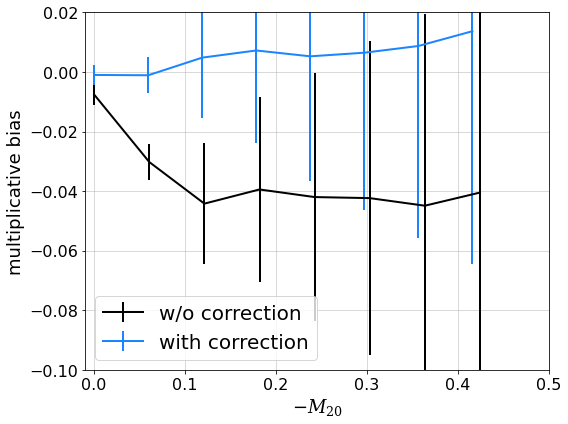

In [157]:
use_sig=False
x=[]
y1=[]
y2=[]
yerr=[]


plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
    
xlabel='$-M_{20}$'
ax.set_xlim(-0.01,0.5)
selnm='pdet_v21'
cornm='fpfs_RS021'

scol1=detM1[selnm]
scol2=detM2[selnm]
ccol1=ellM1[cornm]
ccol2=ellM2[cornm]

dcc=0.06 # delta cut
cutB=0.00 # 
cutsig=0.08
    
for i in range(0,8):
    # update cut array
    cut=cutB+dcc*i
    print(cut)
    
    # weight array
    ws1 = np.ones(len(detM1))
    if use_sig:
        _wtmp= sigmoid_func(scol1,mu=cut,sigma=cutsig)
    else:
        _wtmp= truncSine_func(scol1,mu=cut,sigma=cutsig)
    ws1=ws1*_wtmp
        
    # weight array
    ws2 = np.ones(len(detM2))
    if use_sig:
        _wtmp= sigmoid_func(scol2,mu=cut,sigma=cutsig)
    else:
        _wtmp= truncSine_func(scol2,mu=cut,sigma=cutsig)
    ws2=ws2*_wtmp

    cor1,cor1b = get_selbias(scol1,ccol1,ws1,cut,cutsig)
    cor2,cor2b = get_selbias(scol2,ccol2,ws2,cut,cutsig)
    de   = np.sum(ellM2['fpfs_e1']*ws2)-np.sum(ellM1['fpfs_e1']*ws1)
    rave = (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1))/2.
    raveR= (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1)+cor1+cor2)/2.
    x.append(cut)
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((ellM2['fpfs_RE']*ws2)**2.))/raveR/0.04)
gc.collect()

ax.errorbar(np.array(x)*1.01,np.array(y1),np.array(yerr),label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)/1.01,np.array(y2),np.array(yerr),label='with correction',color=pltutil.colors[1])
ax.set_xlabel(xlabel)
ax.set_ylabel('multiplicative bias')
ax.set_ylim(-0.10,0.02)
ax.grid()
ax.legend()
plt.tight_layout()
#fig.savefig('../../html/noisy_knownRef_%s.png' %pn)
print(y2)

0.0
0.06
0.12
0.18
0.24
0.3
0.36
0.42
[0.0010675577325716112, 0.005326230916922192, 0.005707548911161986, 0.002386782673527321, 0.0011642646210707763, 0.0008870667736671223, 0.0008978991685866244, 0.0005566629985940263]


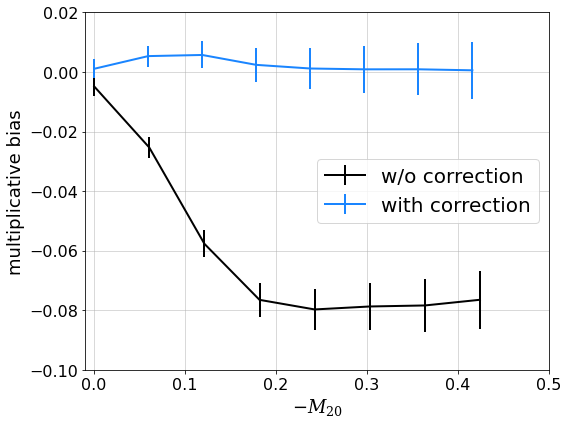

In [153]:
use_sig=False
x=[]
y1=[]
y2=[]
yerr=[]


plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
    
xlabel='$-M_{20}$'
ax.set_xlim(-0.01,0.5)
selnm='fpfs_M20'
cornm='fpfs_RS2'

scol1=-outNN1[selnm]
scol2=-outNN2[selnm]
ccol1=-ellM1[cornm]
ccol2=-ellM2[cornm]

dcc=0.06 # delta cut
cutB=0.00 # 
cutsig=0.08
    
for i in range(0,8):
    # update cut array
    cut=cutB+dcc*i
    print(cut)
    
    # weight array
    ws1 = np.ones(len(detM1))
    if use_sig:
        _wtmp= sigmoid_func(scol1,mu=cut,sigma=cutsig)
    else:
        _wtmp= truncSine_func(scol1,mu=cut,sigma=cutsig)
    ws1=ws1*_wtmp
        
    # weight array
    ws2 = np.ones(len(detM2))
    if use_sig:
        _wtmp= sigmoid_func(scol2,mu=cut,sigma=cutsig)
    else:
        _wtmp= truncSine_func(scol2,mu=cut,sigma=cutsig)
    ws2=ws2*_wtmp

    cor1,cor1b = get_selbias(scol1,ccol1,ws1,cut,cutsig)
    cor2,cor2b = get_selbias(scol2,ccol2,ws2,cut,cutsig)
    de   = np.sum(ellM2['fpfs_e1']*ws2)-np.sum(ellM1['fpfs_e1']*ws1)
    rave = (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1))/2.
    raveR= (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1)+cor1+cor2)/2.
    x.append(cut)
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((ellM2['fpfs_RE']*ws2)**2.))/raveR/0.04)
gc.collect()

ax.errorbar(np.array(x)*1.01,np.array(y1),np.array(yerr),label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)/1.01,np.array(y2),np.array(yerr),label='with correction',color=pltutil.colors[1])
ax.set_xlabel(xlabel)
ax.set_ylabel('multiplicative bias')
ax.set_ylim(-0.10,0.02)
ax.grid()
ax.legend()
plt.tight_layout()
#fig.savefig('../../html/noisy_knownRef_%s.png' %pn)
print(y2)

-0.04
0.019999999999999997
0.07999999999999999
0.13999999999999999
0.19999999999999998
0.26
0.32
0.38
[-0.001970045560202416, -0.019195448744232513, -0.006142500145207119, -0.00205777186478473, -0.0011411840834733011, -0.0008688435065981048, -0.0006116727169097613, -0.0006379531110554115]


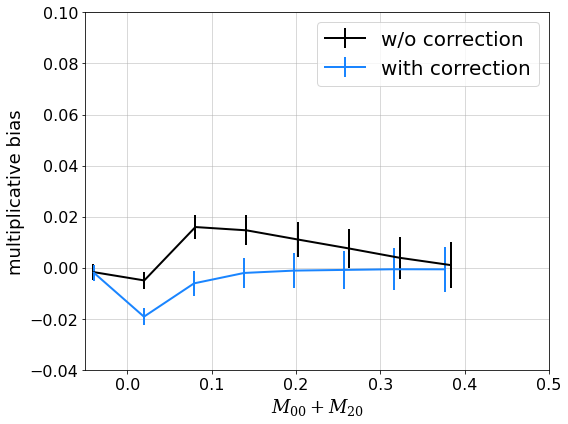

In [154]:
use_sig=False
x=[]
y1=[]
y2=[]
yerr=[]


gc.collect()
plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
    
xlabel='$M_{00}+M_{20}$'
ax.set_xlim(-0.05,0.5)

scol1=outNN1['fpfs_M00']+outNN1['fpfs_M20']
scol2=outNN2['fpfs_M00']+outNN2['fpfs_M20']
ccol1=ellM1['fpfs_RS0']+ellM1['fpfs_RS2']
ccol2=ellM2['fpfs_RS0']+ellM2['fpfs_RS2']

dcc=0.06 # delta cut
cutB=-0.04 # 
cutsig=0.05

for i in range(0,8):
    # update cut array
    cut=cutB+dcc*i
    print(cut)
    
    # weight array
    ws1 = np.ones(len(detM1))
    if use_sig:
        _wtmp= sigmoid_func(scol1,mu=cut,sigma=cutsig)
    else:
        _wtmp= truncSine_func(scol1,mu=cut,sigma=cutsig)
    ws1=ws1*_wtmp
        
    # weight array
    ws2 = np.ones(len(detM2))
    if use_sig:
        _wtmp= sigmoid_func(scol2,mu=cut,sigma=cutsig)
    else:
        _wtmp= truncSine_func(scol2,mu=cut,sigma=cutsig)
    ws2=ws2*_wtmp

    cor1,cor1b = get_selbias(scol1,ccol1,ws1,cut,cutsig)
    cor2,cor2b = get_selbias(scol2,ccol2,ws2,cut,cutsig)
    de   = np.sum(ellM2['fpfs_e1']*ws2)-np.sum(ellM1['fpfs_e1']*ws1)
    rave = (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1))/2.
    raveR= (np.sum(ellM2['fpfs_RE']*ws2)+np.sum(ellM1['fpfs_RE']*ws1)+cor1+cor2)/2.
    x.append(cut)
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((ellM2['fpfs_RE']*ws2)**2.))/raveR/0.04)
gc.collect()

ax.errorbar(np.array(x)*1.01,np.array(y1),np.array(yerr),label='w/o correction',color=pltutil.colors[0])
ax.errorbar(np.array(x)/1.01,np.array(y2),np.array(yerr),label='with correction',color=pltutil.colors[1])
ax.set_xlabel(xlabel)
ax.set_ylabel('multiplicative bias')
ax.set_ylim(-0.04,0.10)
ax.grid()
ax.legend()
plt.tight_layout()
#fig.savefig('../../html/noisy_knownRef_%s.png' %pn)
print(y2)